In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#!pip uninstall tensorflow

In [ ]:
#!pip install tensorflow==2.5.0

In [2]:
!pip list | grep tensorflow

tensorflow                    2.5.0              
tensorflow-datasets           4.0.1              
tensorflow-estimator          2.5.0              
tensorflow-gcs-config         2.5.0              
tensorflow-hub                0.12.0             
tensorflow-metadata           1.0.0              
tensorflow-probability        0.12.1             


In [1]:
import sys
sys.path.insert(0,'/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/unet_architecture')
sys.path.insert(0,'/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data')
from unet import unet
from helpers import display, load_data, plot_train_hist, calculateClassIOU


In [2]:
import os, glob
import matplotlib.pyplot as plt
import numpy as np
import pickle
import nibabel as nb
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
from tqdm.notebook import tqdm
from sys import getsizeof
from tensorflow.keras.models import load_model
from datetime import datetime

import nibabel as nib

In [3]:
model

NameError: ignored

In [4]:
tf.keras.backend.clear_session()
del model

NameError: ignored

In [5]:
512/4

128.0

In [8]:
# Define constants

# Path variables
data_dir = '/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/'
data_dir_train_image = os.path.join(data_dir, 'data_splits_preprocessed/training/img:-1000:1000/img/')
data_dir_train_mask = os.path.join(data_dir,  'data_splits_preprocessed/training/couinaud/img/')

data_dir_test_image = os.path.join(data_dir, 'data_splits_preprocessed/testing/img:-1000:1000/img/')
data_dir_test_mask = os.path.join(data_dir, 'data_splits_preprocessed/testing/couinaud/img/')

data_dir_validate_image = os.path.join(data_dir, 'data_splits_preprocessed/validate/img:-1000:1000/img/')
data_dir_validate_mask = os.path.join(data_dir, 'data_splits_preprocessed/validate/couinaud/img/')

class_names = ['class_0','class_1','class_2','class_3',
               'class_4','class_5','class_6','class_7','class_8']

# Training variables
SEED = 7
BATCH_SIZE_TRAIN = 10
BATCH_SIZE_TEST = 10
BATCH_SIZE_VALIDATE = 10
NUM_TRAIN = 9288
NUM_TEST = 1042
NUM_VALIDATE = 1207

N_CLASSES = 9
BATCH_SIZE_LIST = [12,16,32,64,128]


# Image variables
IMAGE_HEIGHT = int(512/4)
IMAGE_WIDTH = int(512/4)
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)


#Original Image size
OG_IMAGE_HEIGHT = 512
OG_IMAGE_WIDTH = 512
OG_IMG_SIZE = (OG_IMAGE_HEIGHT, OG_IMAGE_WIDTH)

NUM_EPOCH = 100

#Load Data 

In [9]:
#Load data
scaled_train_images    = load_data(data_dir_train_image, isPNG=True, resize=True, NEW_IMG_SIZE=IMG_SIZE)
scaled_train_masks     = load_data(data_dir_train_mask, isPNG=False, resize=True, NEW_IMG_SIZE=IMG_SIZE)

scaled_validate_images = load_data(data_dir_validate_image, isPNG=True, resize=True, NEW_IMG_SIZE=IMG_SIZE)
scaled_validate_masks  = load_data(data_dir_validate_mask, isPNG=False, resize=True, NEW_IMG_SIZE=IMG_SIZE)


Dimmensions:  (9288, 128, 128)
Data Type  :  <class 'numpy.uint8'>
Size in MB :  145.13





Dimmensions:  (9288, 128, 128)
Data Type  :  <class 'numpy.uint8'>
Size in MB :  145.13





Dimmensions:  (1207, 128, 128)
Data Type  :  <class 'numpy.uint8'>
Size in MB :  18.86





Dimmensions:  (1207, 128, 128)
Data Type  :  <class 'numpy.uint8'>
Size in MB :  18.86




In [10]:
#Shuffle the training data
from sklearn.utils import shuffle
scaled_train_images, scaled_train_masks = shuffle(scaled_train_images,scaled_train_masks, random_state = SEED)

In [11]:
#Expand dimensions (print size and type for sanity check)

scaled_train_images = np.expand_dims(scaled_train_images, axis=3).astype('float32')
scaled_validate_images = np.expand_dims(scaled_validate_images, axis=3).astype('float32')

print('#### IMAGES ###')
print(scaled_train_images.shape)
print(type(scaled_train_images[0,0,0,0]))

print(scaled_validate_images.shape)
print(type(scaled_validate_images[0,0,0,0]))

##########################################################################
scaled_train_masks = np.expand_dims(scaled_train_masks, axis=3).astype('float32')
scaled_validate_masks = np.expand_dims(scaled_validate_masks, axis=3).astype('float32')

print('#### MASKS ###')
print(scaled_train_masks.shape)
print(type(scaled_train_masks[0,0,0,0]))

print(scaled_validate_masks.shape)
print(type(scaled_validate_masks[0,0,0,0]))

#### IMAGES ###
(9288, 128, 128, 1)
<class 'numpy.float32'>
(1207, 128, 128, 1)
<class 'numpy.float32'>
#### MASKS ###
(9288, 128, 128, 1)
<class 'numpy.float32'>
(1207, 128, 128, 1)
<class 'numpy.float32'>


#Encode Masks

In [12]:
#Encode labels for all masks
scaled_train_masks = to_categorical(scaled_train_masks, num_classes=N_CLASSES)

print(scaled_train_masks.shape)
print(type(scaled_train_masks[0,0,0,0]))
round(getsizeof(scaled_train_masks) / 1024 / 1024 / 1024 ,2) #GB 

(9288, 128, 128, 9)
<class 'numpy.float32'>


0.0

In [14]:
scaled_validate_masks = to_categorical(scaled_validate_masks, num_classes=N_CLASSES)


print(scaled_validate_masks.shape)
print(type(scaled_validate_masks[0,0,0,0]))
round(getsizeof(scaled_validate_masks) / 1024 / 1024 / 1024 ,2) #GB 

(1207, 128, 128, 9)
<class 'numpy.float32'>


0.0

#Train Multiple Models

Epoch 1/100
774/774 [==============================] - 25s 28ms/step - loss: 0.1765 - mean_io_u: 0.7691 - val_loss: 0.1032 - val_mean_io_u: 0.7994
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0526_06:40/assets
Epoch 2/100
774/774 [==============================] - 22s 28ms/step - loss: 0.0748 - mean_io_u: 0.8117 - val_loss: 0.0628 - val_mean_io_u: 0.8479
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0526_06:40/assets
Epoch 3/100
774/774 [==============================] - 21s 28ms/step - loss: 0.0510 - mean_io_u: 0.8291 - val_loss: 0.0487 - val_mean_io_u: 0.8440
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0526_06:40/assets
Epoch 4/100
774/774 [==============================] - 21s 28ms/step - loss: 0.041

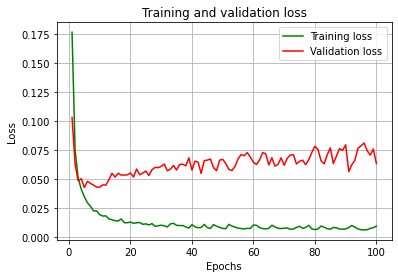

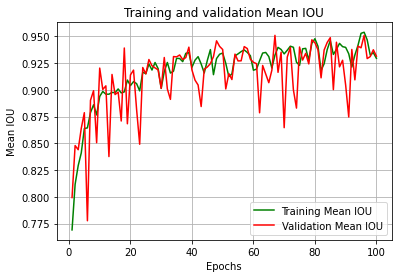

Epoch 1/100
580/580 [==============================] - 23s 36ms/step - loss: 0.1787 - mean_io_u: 0.7818 - val_loss: 0.0881 - val_mean_io_u: 0.7915
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0526_07:16/assets
Epoch 2/100
580/580 [==============================] - 21s 36ms/step - loss: 0.0808 - mean_io_u: 0.7963 - val_loss: 0.0765 - val_mean_io_u: 0.7782
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0526_07:16/assets
Epoch 3/100
580/580 [==============================] - 21s 36ms/step - loss: 0.0570 - mean_io_u: 0.8113 - val_loss: 0.0577 - val_mean_io_u: 0.8230
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0526_07:16/assets
Epoch 4/100
580/580 [==============================] - 21s 36ms/step - loss: 0.059

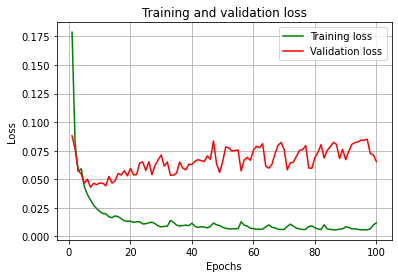

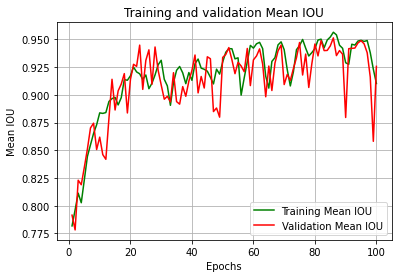

Epoch 1/100
290/290 [==============================] - 21s 65ms/step - loss: 0.2171 - mean_io_u: 0.7782 - val_loss: 0.1229 - val_mean_io_u: 0.7892
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0526_07:51/assets
Epoch 2/100
290/290 [==============================] - 19s 65ms/step - loss: 0.1031 - mean_io_u: 0.7974 - val_loss: 0.0874 - val_mean_io_u: 0.7590
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0526_07:51/assets
Epoch 3/100
290/290 [==============================] - 19s 64ms/step - loss: 0.0674 - mean_io_u: 0.8083 - val_loss: 0.0986 - val_mean_io_u: 0.8046
Epoch 4/100
290/290 [==============================] - 19s 64ms/step - loss: 0.0720 - mean_io_u: 0.8014 - val_loss: 0.1063 - val_mean_io_u: 0.8035
Epoch 5/100
290/290 [==============================] - 19s 64ms/step - loss: 0.0597 - mean_io_

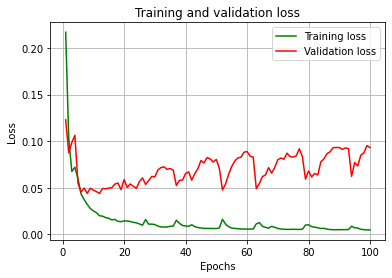

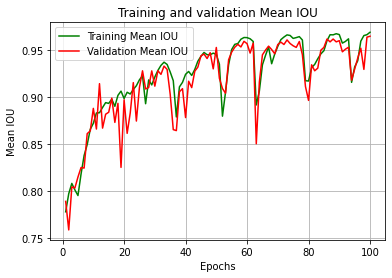

Epoch 1/100
145/145 [==============================] - 21s 122ms/step - loss: 0.2953 - mean_io_u: 0.7244 - val_loss: 0.1418 - val_mean_io_u: 0.7790
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0526_08:23/assets
Epoch 2/100
145/145 [==============================] - 17s 119ms/step - loss: 0.1165 - mean_io_u: 0.7752 - val_loss: 0.1179 - val_mean_io_u: 0.6729
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0526_08:23/assets
Epoch 3/100
145/145 [==============================] - 17s 119ms/step - loss: 0.0905 - mean_io_u: 0.7699 - val_loss: 0.0690 - val_mean_io_u: 0.8004
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0526_08:23/assets
Epoch 4/100
145/145 [==============================] - 17s 118ms/step - loss: 0

KeyboardInterrupt: ignored

In [15]:
for size in BATCH_SIZE_LIST:
  BATCH_SIZE_TRAIN = size
  BATCH_SIZE_VALIDATE = size 

  #Get time for modelname
  all_names = []
  now = datetime.now()
  dt_string = now.strftime("%m%d_%H:%M")
  all_names.append(dt_string)

  #Check point and output path 
  checkpoint_filepath = '/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/' + dt_string + '/'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False,
      monitor='val_loss',
      mode='auto',
      save_best_only=True)

  # Batches per epoch
  EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
  EPOCH_STEP_VALIDATE = NUM_VALIDATE // BATCH_SIZE_VALIDATE

  #Create/Compile Model 
  model = unet(n_levels= 4, IMAGE_HEIGHT=IMAGE_HEIGHT, IMAGE_WIDTH=IMAGE_WIDTH, out_channels=9)
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [tf.keras.metrics.MeanIoU(num_classes=N_CLASSES)])

  #TRAIN MODEL
  history = model.fit(scaled_train_images, scaled_train_masks, 
                    batch_size = BATCH_SIZE_TRAIN, 
                    steps_per_epoch=EPOCH_STEP_TRAIN,  
                    validation_data=(scaled_validate_images, scaled_validate_masks), 
                    validation_steps=EPOCH_STEP_VALIDATE,
                    epochs = NUM_EPOCH,
                    callbacks=[model_checkpoint_callback])
  
  #plot the train metric history at each epoch
  plot_train_hist(history, plt_acc=False, plt_mean_iou=True)

  #Clear Memory
  tf.keras.backend.clear_session()
  del model

print("Models Created: ", all_names)

#Evaluate All Models and Find Best

In [ ]:
#Load Testing Images  
test_images        = load_data(data_dir_test_image, isPNG=True, resize=False, NEW_IMG_SIZE=OG_IMG_SIZE)
scaled_test_images = load_data(data_dir_test_image, isPNG=True, resize=True, NEW_IMG_SIZE=IMG_SIZE)

In [ ]:
#Test masks but no encoding for calculating IOU
test_masks_no_encode        = load_data(data_dir_test_mask, isPNG=False, resize=False, NEW_IMG_SIZE=OG_IMG_SIZE) 
scaled_test_masks_no_encode = load_data(data_dir_test_mask, isPNG=False, resize=True, NEW_IMG_SIZE=IMG_SIZE)


test_masks_no_encode = np.expand_dims(test_masks_no_encode, axis=3)
scaled_test_masks_no_encode = np.expand_dims(scaled_test_masks_no_encode, axis=3)

print(test_masks_no_encode.shape)
print(scaled_test_masks_no_encode.shape)

In [ ]:
from tensorflow.keras.metrics import MeanIoU
all_mean_ious = []

for model in all_names:
  print('------Model:-------', model, '------------------')
  model_path = '/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/' + model + '/'
  imported_model = load_model(model_path)

  #IOU
  mask_pred=imported_model.predict(scaled_test_images)
  mask_pred_argmax=np.argmax(mask_pred, axis=3) #Convert the probability into a max value within the area \
  #ex: lets say we have three labels/categories
  # [0,0.1,0] [0,0.05,0] [0,0.9,0] -> [0,0,0] [0,0,0] [0,1,0]

  IOU = MeanIoU(num_classes=N_CLASSES)  
  IOU.update_state(scaled_test_masks_no_encode[:,:,:,0], mask_pred_argmax)
  print("Mean IoU =", IOU.result().numpy())
  all_mean_ious.append(IOU.result().numpy())

  #Get confusion Matrix
  cm = np.array(IOU.get_weights()).reshape(N_CLASSES, N_CLASSES)
  
  #To calculate I0U for each class...
  calculateClassIOU(cm, 9)

  #Clear Memory
  tf.keras.backend.clear_session()
  del model

max_val = max(all_mean_ious)
max_index = all_mean_ious.index(max_val)
best_model = all_names[max_index]
print('\n===========================================')
print('Best Model is: ', best_model)#prev_best= 0.5916435


#Visualize Results with Best Model

In [33]:
model_path = '/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/' + best_model + '/'
imported_model = load_model(model_path)

mask_pred=imported_model.predict(scaled_test_images)
mask_pred_argmax=np.argmax(mask_pred, axis=3)

In [ ]:
for i in range(0,100):
  print("Instance in test dataset: ", i)
  titles = ["scaled image", "scaled mask", "predicted"]
  display([np.expand_dims(scaled_test_images[i], axis=2), scaled_test_masks_no_encode[i], np.expand_dims(mask_pred_argmax[i], axis=2)], title_list=titles)
  print("==================================================================================================================")

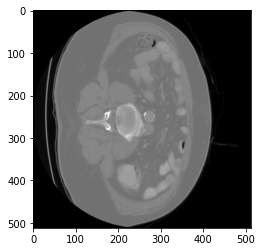

In [43]:
plt.imshow(test_images[0], cmap = 'gray')

In [ ]:
# for i in range(0,50):
#   print("Instance in test dataset: ", i)
#   display([scaled_test_images[i], scaled_test_masks_no_encode[i], np.expand_dims(mask_pred_argmax[i], axis=2)])
#   mask_pred_argmaxOGSHAPE = cv2.resize(mask_pred_argmax[i].astype('float32')  , OG_IMG_SIZE, interpolation = cv2.INTER_LINEAR)
#   display([np.expand_dims(test_images[i], axis=2), test_masks_no_encode[i], np.expand_dims(mask_pred_argmaxOGSHAPE, axis=2)])
#   print("==================================================================================================================")

In [ ]:
tf.keras.backend.clear_session()
del imported_model